## Bible-1_06_Ensemble
Please visit below links, Ensemble theories and Implementation are explained.

## English


*   Theory : https://wikidocs.net/165452 and https://wikidocs.net/165453 and https://wikidocs.net/165454 and https://wikidocs.net/165454
*   Implementation : https://wikidocs.net/165473 and https://wikidocs.net/165474  and https://wikidocs.net/165475


## 한글



*   이론 : https://wikidocs.net/164322 and https://wikidocs.net/164645 and https://wikidocs.net/164307 and https://wikidocs.net/164356
*   구현 : https://wikidocs.net/165167 and https://wikidocs.net/164740 and https://wikidocs.net/165000



To start using a simple sequential model, change the code from "04_02_MNIST_TF2_graph_mode_CNN_subclass.py" to "06_00_graph_mode_CNN_sequential_from_ch4.py".

You can find "04_02_MNIST_TF2_graph_mode_CNN_subclass.py" from Github https://github.com/RichardMinsooGo/Bible-1_04_CNN as start python code.

Below is the same as baseline code.

11501568/11490434 [==============================] - 0s 0us/step
[5 0 4 1 9 2 1 3 1 4]
(60000, 28, 28)
(60000, 28, 28, 1)


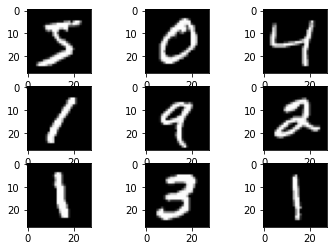

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import Model, Sequential

import matplotlib.pyplot as plt
import numpy as np

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 256 
num_classes = 10
EPOCHS = 5
batch_size = 100
learning_rate = 0.001

# print(tf.__version__)
## MNIST Dataset #########################################################
mnist = tf.keras.datasets.mnist
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
# mnist = tf.keras.datasets.fashion_mnist
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()    

# Change data type as float. If it is unt type, it might cause error 
X_train, X_test = X_train / 255.0, X_test / 255.0

print(Y_train[0:10])
print(X_train.shape)

# in the case of Keras or TF2, type shall be [image_size, image_size, 1]
# if it is RGB type, type shall be [image_size, image_size, 3]
# For MNIST or Fashion MNIST, it need to reshape
X_train_new_axis = X_train[..., tf.newaxis]
X_test_new_axis = X_test[..., tf.newaxis]

print(X_train_new_axis.shape)
    
# 입력된 buffer_size만큼 data를 채우고 무작위로 sampling하여 새로운 data로 바꿉니다.
# 완벽한 셔플링을 위해서는 데이터 세트의 전체 크기보다 크거나 같은 버퍼 크기가 필요합니다.
# 만약 작은 데이터수보다 작은 buffer_size를 사용할경우,
# 처음에 설정된 buffer_size만큼의 data안에서 임의의 셔플링이 발생합니다.
shuffle_size = 100000

train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_new_axis, Y_train)).shuffle(shuffle_size).batch(batch_size)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_new_axis, Y_test)).batch(batch_size)

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    # if you want to invert color, you can use 'gray_r'. this can be used only for MNIST, Fashion MNIST not cifar10
    # pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray_r'))
    
# show the figure
plt.show()

# in the case of Keras or TF2, type shall be [image_size, image_size, 1]

The differences between the sequential model, functional model, and subclassing model are explained in the previous chapter, so please understand the difference.

In [2]:
model = Sequential([
    Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME',input_shape=(28, 28, 1)),
    MaxPool2D(padding='SAME'),
    Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'),
    MaxPool2D(padding='SAME'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

Below is the same as baseline code.

In [3]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = criterion(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = criterion(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

from tqdm import tqdm, tqdm_notebook, trange

for epoch in range(EPOCHS):

    with tqdm_notebook(total=len(train_ds), desc=f"Train Epoch {epoch+1}") as pbar:    
        train_losses = []
        train_accuracies = []
        
        for images, labels in train_ds:
            
            train_step(images, labels)
            
            loss_val= train_loss.result()
            train_losses.append(loss_val)
            acc     = train_accuracy.result()*100
            
            train_accuracies.append(acc)
            
            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(train_losses):.4f}) Acc: {acc:.3f} ({np.mean(train_accuracies):.3f})")

    with tqdm_notebook(total=len(test_ds), desc=f"Test_ Epoch {epoch+1}") as pbar:    
        test_losses = []
        test_accuracies = []
        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)

            loss_val= test_loss.result()
            test_losses.append(loss_val)
            acc     = test_accuracy.result()*100
            
            test_accuracies.append(acc)

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(test_losses):.4f}) Acc: {acc:.3f} ({np.mean(test_accuracies):.3f})")
            


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Train Epoch 1:   0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Test_ Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]